In [1]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from astroquery.gaia import Gaia
from gala.coordinates import GD1Koposov10, reflex_correct
import matplotlib.pyplot as plt
import pandas as pd

from episode_functions import *

Important:  Gaia archive will be intermittently unavailable due to scheduled maintenance on 13-01-2025 from 08:00 to 18:00 (CET)


In [2]:
filename = 'gd1_data.hdf'
centerline_df = pd.read_hdf(filename, 'centerline_df')
selected_df = pd.read_hdf(filename, 'selected_df')

In [3]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)
gd1_frame = GD1Koposov10()

# Transform and Select

## Selection by proper motion

Review:
* queried Gaia for stars in a small region around part of GD1
* transformed to GD1 frame to select stars around center core of GD1
* plotted PM and found phi1 motion of GD1
* selected stars from the original region with this proper motion

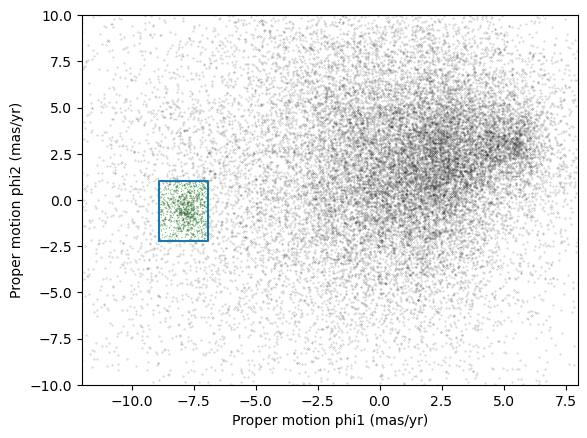

In [4]:
plot_proper_motion(centerline_df)
plt.plot(pm1_rect, pm2_rect)

x = selected_df['pm_phi1']
y = selected_df['pm_phi2']
plt.plot(x, y, 'gx', markersize=0.3, alpha=0.3)

(-20.0, 5.0)

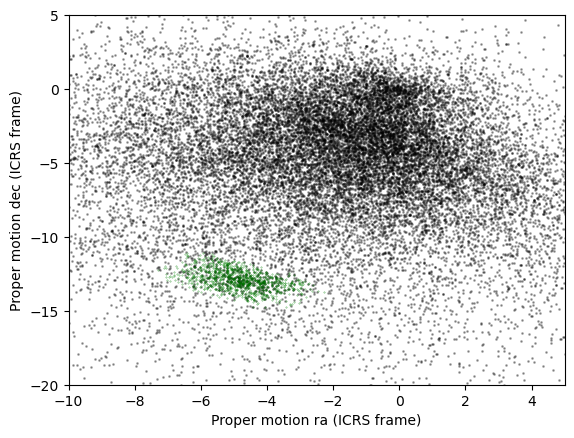

In [5]:
x = centerline_df['pmra']
y = centerline_df['pmdec']
plt.plot(x, y, 'ko', markersize=1, alpha=0.3)

x = selected_df['pmra']
y = selected_df['pmdec']
plt.plot(x, y, 'gx', markersize=1, alpha=0.3)

plt.xlabel('Proper motion ra (ICRS frame)')
plt.ylabel('Proper motion dec (ICRS frame)')

plt.xlim(-10, 5)
plt.ylim(-20, 5)

## Exercise
Looking at the proper motin of the stars we identified along the centerline of GD-1, in the ICRS reference frame define a rectangle (pmra_min, pmra_max, pmdec_min, pmdec_max) that encompass the proper motion of the majority of the stars near the centerline of GD01 without including too much contamination from other stars

In [6]:
pmra_min = -6.7
pmra_max = -3
pmdec_min = -14.31
pmdec_max = -11.2

## Assembling the query

In [7]:
candidate_coord_query_base = """SELECT
{columns} 
FROM gaiadr2.gaia_source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec),
                     POLYGON({sky_point_list}))
"""

Select larger region

In [8]:
phi1_min = -70 *u.degree
phi1_max = -20 * u.degree
phi2_min = -5 * u.degree
phi2_max = 5 * u.degree

make x and y arrays for rectangle in spatial coordinates

In [9]:
phi1_rect, phi2_rect = make_rectangle(phi1_min, phi1_max, phi2_min, phi2_max)

make SkyCoord objct for corners in gd1 frame and transform to icrs

In [10]:
corners = SkyCoord(phi1=phi1_rect,
                   phi2=phi2_rect,
                   frame=gd1_frame)
corners_icrs = corners.transform_to('icrs')

create list for POLYGON call

In [11]:
sky_point_list = skycoord_to_string(corners_icrs)
sky_point_list

'135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862'

In [12]:
columns = 'source_id, ra, dec, pmra, pmdec'

### DO NOT RUN THIS QUERY
we haven't added in the PM filter so a lot of stars still

In [25]:
candidate_coord_query = candidate_coord_query_base.format(columns=columns, 
                                                          sky_point_list=sky_point_list)
print(candidate_coord_query)

SELECT
source_id, ra, dec, pmra, pmdec 
FROM gaiadr2.gaiasource
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec),
                     POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))



## Selecting proper motion

## Exercise
Define candidate_coord_pm_query_base, starting with candidate_coord_query_base and adding two new BETWEEN clauses to select stars whose coordinates of proper motion, pmra and pmdec, fall within the region dfined by pmra_min, pmra_max, pmdec_min , pmdec_max. In the next exercise we will use the format statement to fill in the values we defined above

In [14]:
candidate_coord_pm_query_base = """SELECT
{columns} 
FROM gaiadr2.gaia_source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec),
                     POLYGON({sky_point_list}))
    AND pmra BETWEEN {pmra_min} AND {pmra_max}
    AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

## Exercise
use format to format candidate_coord_pm_query_base and define candidate_coord_pm_query, filling in the values of columns, sky_point_listm pmra_min, pmra_max, pmdec_min, pmdec_max

In [15]:
candidate_coord_pm_query = candidate_coord_pm_query_base.format(columns=columns, 
                                  sky_point_list=sky_point_list,
                                  pmra_min=pmra_min,
                                  pmra_max=pmra_max,
                                  pmdec_min=pmdec_min,
                                  pmdec_max=pmdec_max)
print(candidate_coord_pm_query)

SELECT
source_id, ra, dec, pmra, pmdec 
FROM gaiadr2.gaia_source
WHERE parallax < 1
    AND bp_rp BETWEEN -0.75 AND 2
    AND 1 = CONTAINS(POINT(ra, dec),
                     POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
    AND pmra BETWEEN -6.7 AND -3
    AND pmdec BETWEEN -14.31 AND -11.2



Now we can run it

In [16]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)
print(candidate_coord_pm_job)

INFO: Query finished. [astroquery.utils.tap.core]
<Table length=8409>
   name    dtype    unit                              description                            
--------- ------- -------- ------------------------------------------------------------------
SOURCE_ID   int64          Unique source identifier (unique within a particular Data Release)
       ra float64      deg                                                    Right ascension
      dec float64      deg                                                        Declination
     pmra float64 mas / yr                         Proper motion in right ascension direction
    pmdec float64 mas / yr                             Proper motion in declination direction
Jobid: 1736659472686O
Phase: COMPLETED
Owner: None
Output file: async_20250112052433.vot
Results: None


In [17]:
candidate_gaia_table = candidate_coord_pm_job.get_results()
len(candidate_gaia_table)

8409

Discuss why we have to use BETWEEN and not POLYGON here

In [18]:
d = dict(sky_point_list=sky_point_list, pmra_min=pmra_min, pmra_max=pmra_max, pmdec_min=pmdec_min, pmdec_max=pmdec_max)
d

{'sky_point_list': '135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862',
 'pmra_min': -6.7,
 'pmra_max': -3,
 'pmdec_min': -14.31,
 'pmdec_max': -11.2}

In [19]:
point_series = pd.Series(d)
point_series

sky_point_list    135.306, 8.39862, 126.51, 13.4449, 163.017, 54...
pmra_min                                                       -6.7
pmra_max                                                         -3
pmdec_min                                                    -14.31
pmdec_max                                                     -11.2
dtype: object

In [20]:
filename = 'gd1_data.hdf'
point_series.to_hdf(filename, key='point_series')

/var/folders/6l/54htg8p52b762n_6mhsb13v80000gn/T/ipykernel_57880/290492992.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->values] [items->None]

  point_series.to_hdf(filename, key='point_series')


## Plotting one more time

Text(0, 0.5, 'dec (degree ICRS)')

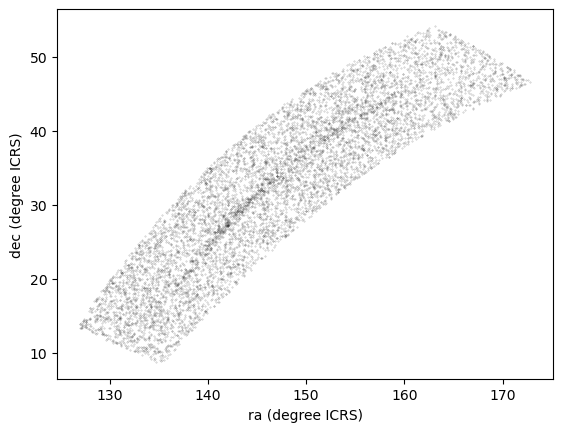

In [21]:
x = candidate_gaia_table['ra']
y = candidate_gaia_table['dec']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('ra (degree ICRS)')
plt.ylabel('dec (degree ICRS)')

In [22]:
candidate_gaia_df = make_dataframe(candidate_gaia_table)

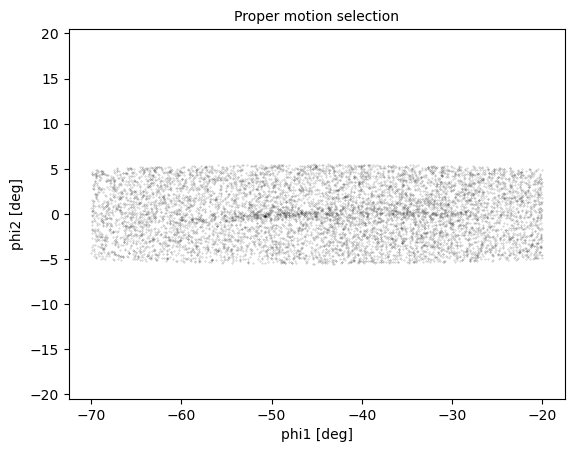

In [23]:
plot_pm_selection(candidate_gaia_df)

# Join

GD1 is thought to be a tidally stretched globular cluster - which means the stars were all created at the same time. This means we can build a color magnitude diagram and indentify the stars that all have the same age and filter on that isochrone

## Getting photometry data

* Gaia has BP-RP, we are already using this to eliminate M dwarfs. But we can do better with narrower filters
* Use Pan-STARRS
* Gaia provides a cross-match to Pan-STARRS which we will use. Not all catalogs do this - but astropy contains functions to help you cross-match tables if this hasn't already been done for you

## The best neighbor table

* Gaia objects have unique identifier source_id
* Pan-STARRS have unique identifier obj_id
* The best neighbor table provides a mapping between source_id and obj_id
* we can then use obj_id to get photometry from stars in panstarrs1_original_value
* note the british spelling of neighbours

Look at the metadata for panstarrs1_best_neighbour

In [24]:
ps_best_neighbour_meta = Gaia.load_table('gaiadr2.panstarrs1_best_neighbour')
print(ps_best_neighbour_meta)

TAP Table name: gaiadr2.gaiadr2.panstarrs1_best_neighbour
Description: Pan-STARRS1 BestNeighbour table lists each matched Gaia object with its
best neighbour in the external catalogue.
There are 1 327 157 objects in the filtered version of Pan-STARRS1 used
to compute this cross-match that have too early epochMean.
Num. columns: 7


Look at columns

In [25]:
for column in ps_best_neighbour_meta.columns:
    print(column.name)

source_id
original_ext_source_id
angular_distance
number_of_neighbours
number_of_mates
best_neighbour_multiplicity
gaia_astrometric_params


* source_id: gaia id
* best_neighbour_multiplicity: how many PanSTARRS objects matched to this Gaia object - ideally this is 1
* number_of_mates: how many other Gaia sources were matched to the PanSTARRS objects - ideally this is 0
* original_ext_source_id: obj_id in the PanSTARRS catalog
* if someone asks: number_of_neighbours: number of PanSTARRS objects that match just based on spatial coincidence - before other filtering (like brightness or color)

In [26]:
ps_best_neighbour_query = """SELECT
TOP 5
source_id, best_neighbour_multiplicity, number_of_mates, original_ext_source_id
FROM gaiadr2.panstarrs1_best_neighbour
"""

In [27]:
ps_best_neighbour_job = Gaia.launch_job_async(ps_best_neighbour_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [28]:
ps_best_neighbour_results = ps_best_neighbour_job.get_results()
ps_best_neighbour_results

SOURCE_ID,best_neighbour_multiplicity,number_of_mates,original_ext_source_id
int64,int16,int16,int64
6745938972433480704,1,0,69742925668851205
6030466788955954048,1,0,69742509325691172
6756488099308169600,1,0,69742879438541228
6700154994715046016,1,0,69743055581721207
6757061941303252736,1,0,69742856540241198


## The Pan-STARRS table

Not that we have the obj_id for PanSTARRS we can use it to get the photometry for these objects from panstarrs1_original_valid

In [29]:
ps_valid_meta = Gaia.load_table('gaiadr2.panstarrs1_original_valid')

In [30]:
print(ps_valid_meta)

TAP Table name: gaiadr2.gaiadr2.panstarrs1_original_valid
Description: The Panoramic Survey Telescope and Rapid Response System (Pan-STARRS) is
a system for wide-field astronomical imaging developed and operated by
the Institute for Astronomy at the University of Hawaii. Pan-STARRS1
(PS1) is the first part of Pan-STARRS to be completed and is the basis
for Data Release 1 (DR1). The PS1 survey used a 1.8 meter telescope and
its 1.4 Gigapixel camera to image the sky in five broadband filters (g,
r, i, z, y).

The current table contains a filtered subsample of the 10 723 304 629
entries listed in the original ObjectThin table.
We used only ObjectThin and MeanObject tables to extract
panstarrs1OriginalValid table, this means that objects detected only in
stack images are not included here. The main reason for us to avoid the
use of objects detected in stack images is that their astrometry is not
as good as the mean objects astrometry: “The stack positions (raStack,
decStack) have considera

look at columns

In [31]:
for column in ps_valid_meta.columns:
    print(column.name)

obj_name
obj_id
ra
dec
ra_error
dec_error
epoch_mean
g_mean_psf_mag
g_mean_psf_mag_error
g_flags
r_mean_psf_mag
r_mean_psf_mag_error
r_flags
i_mean_psf_mag
i_mean_psf_mag_error
i_flags
z_mean_psf_mag
z_mean_psf_mag_error
z_flags
y_mean_psf_mag
y_mean_psf_mag_error
y_flags
n_detections
zone_id
obj_info_flag
quality_flag


* obj_id: PanSTARRS id, same as original_ext_souce_id in best neighbour table
* g_mean_psf_mag
* i_mean_psf_mag

explore first 5 rows

In [32]:
ps_valid_query = """SELECT
TOP 5 
obj_id, g_mean_psf_mag, i_mean_psf_mag
FROM gaiadr2.panstarrs1_original_valid
"""

In [33]:
ps_valid_job = Gaia.launch_job_async(ps_valid_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [34]:
ps_valid_results = ps_valid_job.get_results()
ps_valid_results

obj_id,g_mean_psf_mag,i_mean_psf_mag
,,mag
int64,float64,float64
67130655389101425,--,20.3516006469727
67553305590067819,--,19.779899597168
67551423248967849,--,19.8889007568359
67132026238911331,--,20.9062995910645
67553513677687787,--,21.2831001281738


## Joining tables

JOIN: combine tables using a matching column as the key to identify matching rows

gaia_source.source_id = panstarrs1_best_neighbour.source_id  
panstarrs1_best_neighbour.original_ext_source_id = panstarrs1_original_valid.obj_id

results combines all three tables and returns the columns we requested from any of the 3 tables

This is a complex operation - start with a simply toy example and a small number of rows and then build complexity checking every time

Cone search 

In [35]:
test_cone_query = """SELECT
TOP 10 
source_id
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
    POINT(ra, dec),
    CIRCLE(88.8, 7.4, 0.083))
"""

Check that is works

In [36]:
test_cone_job = Gaia.launch_job(test_cone_query)

In [37]:
test_cone_results = test_cone_job.get_results()
test_cone_results

SOURCE_ID
int64
3322773965056065536
3322773758899157120
3322774068134271104
3322773930696320512
3322774377374425728
3322773724537891456
3322773724537891328
3322773930696321792
3322773724537890944


it works! Let's make the columns at variable that we can fill in

In [38]:
cone_base_query = """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
    POINT(ra, dec),
    CIRCLE(88.8, 7.4, 0.083))
"""

In [39]:
columns = 'source_id, ra, dec, pmra, pmdec'
cone_query = cone_base_query.format(columns=columns)
print(cone_query)

SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE 1=CONTAINS(
    POINT(ra, dec),
    CIRCLE(88.8, 7.4, 0.083))



test it

In [40]:
cone_job = Gaia.launch_job_async(cone_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [41]:
cone_results = cone_job.get_results()
cone_results

SOURCE_ID,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907
3322773758899157120,88.83227057144585,7.325577341429926,--,--
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008


## Adding the best neighbour table

JOIN: which table to join to    
ON: how to match the rows between the tables   
AS: give an alias or nickname to a table so you don't have to type as much

In [42]:
neighbours_base_query = """SELECT
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  ON gaia.source_id = best.source_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.083))
"""

Note: instead of ON you can use USING(source_id) if it is the same column

note we specify which table a column is coming from and we can select columns from both tables. We will add best_neighbour_multiplicity and number_of_mates from the best neighbour table which will help us evaluate the quality of our crossmatch

In [43]:
column_list_neighbours = ['gaia.source_id',
                          'gaia.ra', 
                          'gaia.dec',
                          'gaia.pmra',
                          'gaia.pmdec',
                          'best.best_neighbour_multiplicity',
                          'best.number_of_mates'
                         ]
columns = ', '.join(column_list_neighbours)
neighbours_query = neighbours_base_query.format(columns=columns)
print(neighbours_query)


SELECT
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  ON gaia.source_id = best.source_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.083))



our aliases are already saving us typing

test that it works

In [44]:
neighbours_job = Gaia.launch_job_async(neighbours_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [45]:
neighbours_results = neighbours_job.get_results()
neighbours_results

SOURCE_ID,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates
,deg,deg,mas / yr,mas / yr,,
int64,float64,float64,float64,float64,int16,int16
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907,1,0
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044,1,0
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717,1,0
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435,1,0
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086,1,0
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576,1,0
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008,1,0
3322773724537890944,88.81241651540533,7.327864052479726,-0.36003627434304625,-6.393939291541333,1,0


Few entries than before because some Gaia sources have no PanSTARRS match - default is to only include rows for objects that appear in both tables

## Adding the Pan-STARRS table

## Exercise
Now we are ready to bring in the Pan-STARRS table. Starting with the prevous query, add a second JOIN clause that joins with gaiadr2.panstarrs1_original_valid, give it an abbreviatded name ps, and matches original_ext_source_id from the best neighbour table with obj_id from the Pan-STARRS table.

Add g_mean_psf_mag and i_mean_psf_mag to the column list and run the query. The result should contain 490 rows and 9 columns.

In [46]:
join_solution_base_query = """SELECT
{columns}
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid as ps
  ON best.original_ext_source_id=ps.obj_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.083))
"""

In [47]:
column_list_join = ['gaia.source_id',
                          'gaia.ra', 
                          'gaia.dec',
                          'gaia.pmra',
                          'gaia.pmdec',
                          'best.best_neighbour_multiplicity',
                          'best.number_of_mates',
                          'ps.g_mean_psf_mag',
                          'ps.i_mean_psf_mag'
                         ]
columns = ', '.join(column_list_join)
join_solution_query = join_solution_base_query.format(columns=columns)
print(join_solution_query)

SELECT
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.gaia_source AS gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid as ps
  ON best.original_ext_source_id=ps.obj_id
WHERE 1=CONTAINS(
  POINT(gaia.ra, gaia.dec),
  CIRCLE(88.8, 7.4, 0.083))



In [48]:
join_solution_job = Gaia.launch_job_async(join_solution_query)
join_solution_results = join_solution_job.get_results()
join_solution_results

INFO: Query finished. [astroquery.utils.tap.core]


SOURCE_ID,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag
,deg,deg,mas / yr,mas / yr,,,,mag
int64,float64,float64,float64,float64,int16,int16,float64,float64
3322773965056065536,88.78178020183375,7.334936530583141,0.2980633722108194,-2.5057036964736907,1,0,19.9431991577148,17.4221992492676
3322774068134271104,88.8206092188033,7.353158142762173,-1.1065462654445488,-1.5260889445858044,1,0,18.6212005615234,16.6007995605469
3322773930696320512,88.80843339290348,7.334853162299928,2.6074384482375215,-0.9292104395445717,1,0,--,20.2203998565674
3322774377374425728,88.86806108182265,7.371287731275939,3.9555477866915383,-3.8676624830902435,1,0,18.0676002502441,16.9762001037598
3322773724537891456,88.81308602813434,7.32488574492059,51.34995462741039,-33.078133430952086,1,0,20.1907005310059,17.8700008392334
3322773724537891328,88.81570329208743,7.3223019772324855,1.9389988498951845,0.3110526931576576,1,0,22.6308002471924,19.6004009246826
3322773930696321792,88.8050736770331,7.332371472206583,2.264014834476311,1.0772755505138008,1,0,21.2119998931885,18.3528003692627
3322773724537890944,88.81241651540533,7.327864052479726,-0.36003627434304625,-6.393939291541333,1,0,20.8094005584717,18.1343002319336


## Selecting by coordinates and proper motion 

Replace our toy example with GD1 using what we previously built

Add JOINs to our candidate_coord_pm_query_base

In [49]:
candidate_coord_pm_query_base = """SELECT
{columns}
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2
  AND 1 = CONTAINS(POINT(ra, dec),
                   POLYGON({sky_point_list}))
  AND pmra BETWEEN {pmra_min} AND {pmra_max}
  AND pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

In [50]:
columns = 'source_id, ra, dec, pmra, pmdec'
candidate_coord_pm_query = candidate_coord_pm_query_base.format(columns=columns,
                                        sky_point_list=sky_point_list,
                                        pmra_min=pmra_min,
                                        pmra_max=pmra_max,
                                        pmdec_min=pmdec_min,
                                        pmdec_max=pmdec_max)
print(candidate_coord_pm_query)

SELECT
source_id, ra, dec, pmra, pmdec
FROM gaiadr2.gaia_source
WHERE parallax < 1
  AND bp_rp BETWEEN -0.75 AND 2
  AND 1 = CONTAINS(POINT(ra, dec),
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND pmra BETWEEN -6.7 AND -3
  AND pmdec BETWEEN -14.31 AND -11.2



let's test that it works before we build on it

In [51]:
candidate_coord_pm_job = Gaia.launch_job_async(candidate_coord_pm_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [52]:
candidate_coord_pm_results = candidate_coord_pm_job.get_results()
candidate_coord_pm_results

SOURCE_ID,ra,dec,pmra,pmdec
,deg,deg,mas / yr,mas / yr
int64,float64,float64,float64,float64
635559124339440000,137.58671691646745,19.1965441084838,-3.770521900009566,-12.490481778113859
635860218726658176,138.5187065217173,19.09233926905897,-5.941679495793577,-11.346409129876392
635674126383965568,138.8428741026386,19.031798198627634,-3.8970011609340207,-12.702779525389634
635614168640132864,139.59219748145836,18.807955539071433,-3.309602916796381,-13.708904908478631
635523531945742592,137.1439946395468,18.845588306639165,-3.9036930274876585,-11.634380634589444
635821843194387840,139.88094034815086,19.62185456718988,-6.544201177153814,-12.55978220563274
635821980633338624,139.9080311966138,19.638380144036358,-4.045391546526935,-11.966804519012523
635551706931167104,138.04665586038192,19.248909662830798,-6.224595114220405,-12.224246333795001


## Exercise
Create a new query base called candidate_join_query_base that combines the WHERE clauses from the previous query with the JOIN clauses for the best neighbour and Pan-STARRS table. Format the query base using the column names in column_list, and call the result candidate_join_query.

Hint: make sure you use qualified column names everywhere!

Run your query and download the results. the table you get should have 4300 rows and 9 coolumns

In [53]:
candidate_join_query_base = """SELECT
{columns}
FROM gaiadr2.gaia_source as gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid as ps
  ON best.original_ext_source_id=ps.obj_id
WHERE gaia.parallax < 1
  AND gaia.bp_rp BETWEEN -0.75 AND 2
  AND 1 = CONTAINS(POINT(gaia.ra, gaia.dec),
                   POLYGON({sky_point_list}))
  AND gaia.pmra BETWEEN {pmra_min} AND {pmra_max}
  AND gaia.pmdec BETWEEN {pmdec_min} AND {pmdec_max}
"""

columns = ', '.join(column_list_join)

candidate_join_query = candidate_join_query_base.format(columns=columns,
                                        sky_point_list=sky_point_list,
                                        pmra_min=pmra_min,
                                        pmra_max=pmra_max,
                                        pmdec_min=pmdec_min,
                                        pmdec_max=pmdec_max)
print(candidate_join_query)

SELECT
gaia.source_id, gaia.ra, gaia.dec, gaia.pmra, gaia.pmdec, best.best_neighbour_multiplicity, best.number_of_mates, ps.g_mean_psf_mag, ps.i_mean_psf_mag
FROM gaiadr2.gaia_source as gaia
JOIN gaiadr2.panstarrs1_best_neighbour AS best
  ON gaia.source_id = best.source_id
JOIN gaiadr2.panstarrs1_original_valid as ps
  ON best.original_ext_source_id=ps.obj_id
WHERE gaia.parallax < 1
  AND gaia.bp_rp BETWEEN -0.75 AND 2
  AND 1 = CONTAINS(POINT(gaia.ra, gaia.dec),
                   POLYGON(135.306, 8.39862, 126.51, 13.4449, 163.017, 54.2424, 172.933, 46.4726, 135.306, 8.39862))
  AND gaia.pmra BETWEEN -6.7 AND -3
  AND gaia.pmdec BETWEEN -14.31 AND -11.2



In [54]:
candidate_join_job = Gaia.launch_job_async(candidate_join_query)

INFO: Query finished. [astroquery.utils.tap.core]


In [55]:
candidate_table = candidate_join_job.get_results()
len(candidate_table)

4300

## Checking the match

use pandas data exploration describe function to examine the best_neightbour_multiplicity which tell sus about the quality of the match

In [56]:
candidate_table['best_neighbour_multiplicity']

1
1
1
1
1
1
1
1
1
1
1


It looks like these are all 1, but let's use describe to get better stats - first we need to make this astropy Table column and Pandas series

In [57]:
multiplicity = pd.Series(candidate_table['best_neighbour_multiplicity'])
multiplicity.describe()

/Users/bostroem/opt/anaconda3/envs/AstronomicalData/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


count    4300.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
dtype: float64

Numpy mask warning: astropy masked data that is masked in pandas is not masked in numpy

Repeat for number_of_mates - this time we want everything to be 0

In [58]:
mates = pd.Series(candidate_table['number_of_mates'])
mates.describe()

/Users/bostroem/opt/anaconda3/envs/AstronomicalData/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4842: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


count    4300.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
dtype: float64

they are all 0

## Saving the DataFrame

Make a dataframe and save results - this is a big query we just ran. Use our make_dataframe function

In [59]:
candidate_df = make_dataframe(candidate_table)

In [85]:
filename = 'gd1_data.hdf'
candidate_df.to_hdf(filename, key='candidate_df')

In [86]:
from os.path import getsize
MB = 1024 * 1024
getsize(filename)/MB

15.446220397949219

## Another file format - CSV

Pandas has a number of other formats. CSV or comma separated value is the lowest common denominator - can be read and written by almost any langauge or analysis software. It is easy to read and easy to use - but it is a less sophisticated format and therefore has some limitations tha tthe hdf5 files don't (like a lack of meta data, data types, column names). 

Plain text --> can get big

In [87]:
candidate_df.to_csv('gd1_data.csv')

In [89]:
getsize('gd1_data.csv')/MB

0.8787498474121094

Now let's read it back

In [90]:
read_back_csv = pd.read_csv('gd1_data.csv')

compare the original to the read back

In [91]:
candidate_df.head(3)

,SOURCE_ID,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag,phi1,phi2,pm_phi1,pm_phi2
0,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,1,0,17.8978,17.517401,-59.247330,-2.016078,-7.527126,1.748779
1,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,1,0,19.2873,17.678101,-59.133391,-2.306901,-7.560608,-0.741800
2,635614168640132864,139.592197,18.807956,-3.309603,-13.708905,1,0,16.1516,14.666300,-58.938113,-3.024192,-8.062762,-1.869082


In [92]:
read_back_csv.head(3)

,Unnamed: 0,SOURCE_ID,ra,dec,pmra,pmdec,best_neighbour_multiplicity,number_of_mates,g_mean_psf_mag,i_mean_psf_mag,phi1,phi2,pm_phi1,pm_phi2
0,0,635860218726658176,138.518707,19.092339,-5.941679,-11.346409,1,0,17.8978,17.517401,-59.247330,-2.016078,-7.527126,1.748779
1,1,635674126383965568,138.842874,19.031798,-3.897001,-12.702780,1,0,19.2873,17.678101,-59.133391,-2.306901,-7.560608,-0.741800
2,2,635614168640132864,139.592197,18.807956,-3.309603,-13.708905,1,0,16.1516,14.666300,-58.938113,-3.024192,-8.062762,-1.869082


Notice our read back csv gained an extra index column. There are ways to avoid this with reading and writing function but this is an example of what can go wrong with CSV files

# Photometry
## Plotting photometry data

Text(0, 0.5, 'Magnitude (g)')

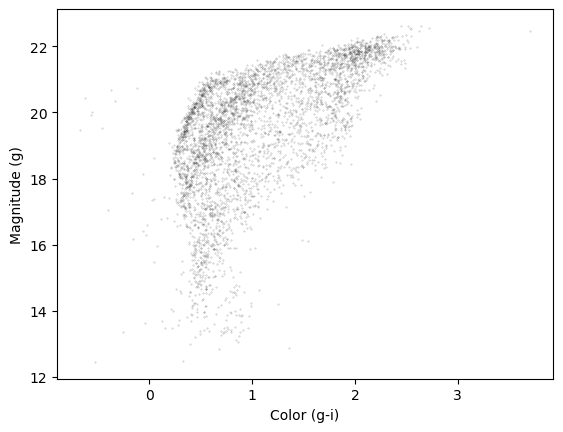

In [60]:
x = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
y = candidate_df['g_mean_psf_mag']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('Color (g-i)')
plt.ylabel('Magnitude (g)')

add limits to invert the axes

(22.0, 14.0)

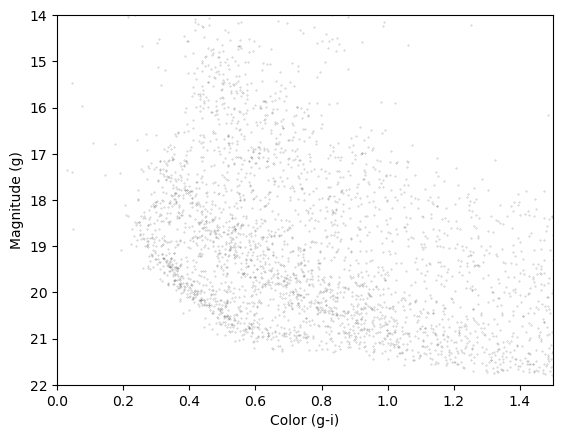

In [61]:
x = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
y = candidate_df['g_mean_psf_mag']
plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('Color (g-i)')
plt.ylabel('Magnitude (g)')

plt.xlim([0, 1.5])
plt.ylim([22, 14])

In [62]:
def plot_cmd(dataframe):
    """Plot a color magnitude diagram.

    dataframe: DataFrame or table with photometry data
    """
    x = dataframe['g_mean_psf_mag']-dataframe['i_mean_psf_mag']
    y = dataframe['g_mean_psf_mag']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlim([0, 1.5])
    plt.ylim([22, 14])

    plt.xlabel('Color (g-i)')
    plt.ylabel('Magnitude (g)')

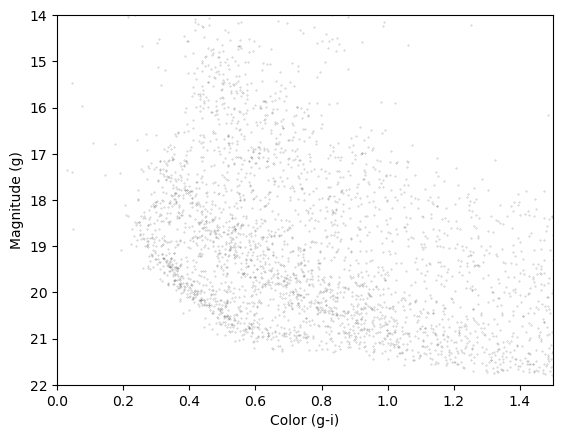

In [63]:
plot_cmd(candidate_df)

## Isochrone

## Making a polygon

In [64]:
filename = 'gd1_isochrone.hdf5'
iso_df = pd.read_hdf(filename, 'iso_df')
iso_df.head()

,mag_g,color_g_i
0,28.294743,2.195021
1,28.189718,2.166076
2,28.051761,2.129312
3,27.916194,2.093721
4,27.780024,2.058585


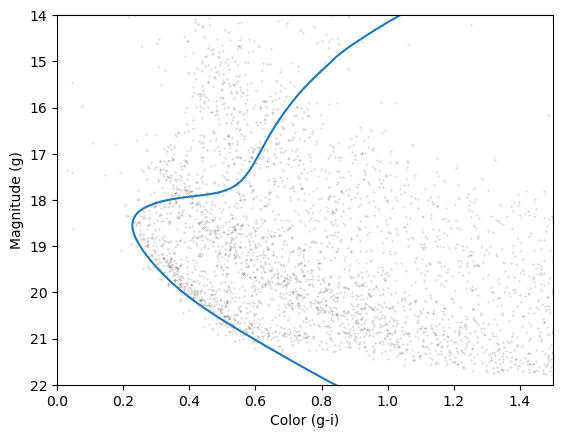

In [65]:
plot_cmd(candidate_df)
plt.plot(iso_df['color_g_i'], iso_df['mag_g'])

In [66]:
g_all = iso_df['mag_g']
g_mask = (g_all > 18.0) & (g_all < 21.5)
g_mask.sum()

np.int64(117)

In [67]:
iso_masked = iso_df[g_mask]
iso_masked.head()

,mag_g,color_g_i
94,21.411746,0.692171
95,21.322466,0.670238
96,21.233380,0.648449
97,21.144427,0.626924
98,21.054549,0.605461


In [68]:
g = iso_masked['mag_g']
left_color = iso_masked['color_g_i'] - 0.06
right_color = iso_masked['color_g_i'] + 0.12

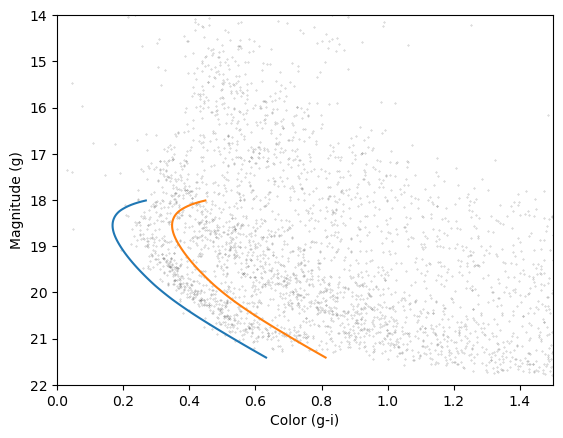

In [69]:
plot_cmd(candidate_df)
plt.plot(left_color, g, label='left color')
plt.plot(right_color, g, label='right color')

## Which points are in the polygon?

In [70]:
reverse_right_color = right_color[::-1]

In [71]:
import numpy as np
color_loop = np.append(left_color, reverse_right_color)
color_loop.shape

(234,)

In [72]:
mag_loop = np.append(g, g[::-1])
mag_loop.shape

(234,)

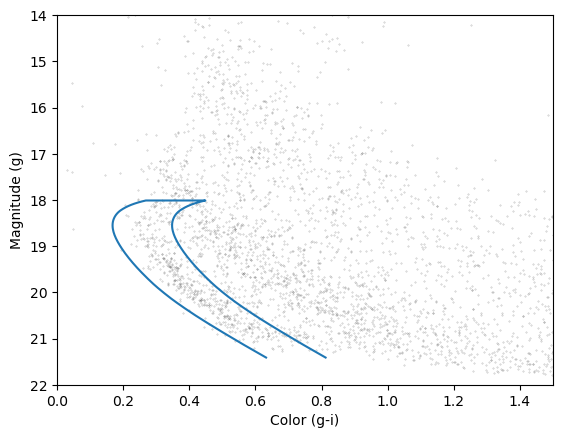

In [73]:
plot_cmd(candidate_df)
plt.plot(color_loop, mag_loop)

Put into a dataframe

In [74]:
loop_df = pd.DataFrame()
loop_df['color_loop'] = color_loop
loop_df['mag_loop'] = mag_loop
loop_df.head()

,color_loop,mag_loop
0,0.632171,21.411746
1,0.610238,21.322466
2,0.588449,21.233380
3,0.566924,21.144427
4,0.545461,21.054549


pass loop_df to Polygon

In [75]:
from matplotlib.patches import Polygon

polygon = Polygon(loop_df)
polygon

## Exercise

When we encounter a new object, it is good to create a toy example to test that it does what we think it does. Define a list of points (represented as two tuples), one that should be inside the polygon and one that should be outside the polygoon. Call to contains_points on the polygon we just created, passing it the list of points you defined, to verify that the results are as expected

In [76]:
points = [(1, 19), (0.5, 20)]
polygon.contains_points(points)

array([False,  True])

## Save the polygon

In [112]:
filename = 'gd1_data.hdf'
loop_df.to_hdf(filename, key='loop_df')

## Selecting based on photometry

In [77]:
cmd_df = pd.DataFrame()
cmd_df['color'] = candidate_df['g_mean_psf_mag'] - candidate_df['i_mean_psf_mag']
cmd_df['mag'] = candidate_df['g_mean_psf_mag']
cmd_df.head()

,color,mag
0,0.380400,17.8978
1,1.609200,19.2873
2,1.485300,16.1516
3,0.686701,18.6709
4,0.384899,16.5224


In [78]:
inside_mask = polygon.contains_points(cmd_df)
inside_mask

array([False, False, False, ..., False, False, False], shape=(4300,))

## Exercise
Boolean values are stored as 0s and 1s. FALSE= 0 and True = 1. Use this information to determine the number of stars that fall inside the polygon

In [79]:
inside_mask.sum()

np.int64(486)

In [80]:
winner_df = candidate_df[inside_mask]

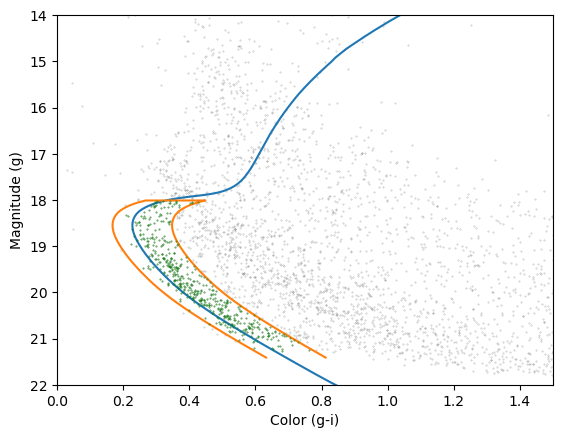

In [81]:
plot_cmd(candidate_df)
plt.plot(iso_df['color_g_i'], iso_df['mag_g'])
plt.plot(color_loop, mag_loop)

x = winner_df['g_mean_psf_mag'] - winner_df['i_mean_psf_mag']
y = winner_df['g_mean_psf_mag']

plt.plot(x, y, 'go', markersize=0.5, alpha=0.5)

(np.float64(-72.25067740005119),
 np.float64(-17.6299180244722),
 np.float64(-5.934485309630674),
 np.float64(5.915026213827362))

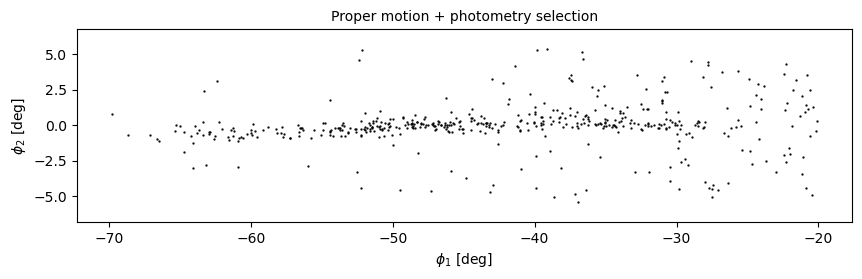

In [82]:
fig = plt.figure(figsize=(10, 2.5))

x = winner_df['phi1']
y = winner_df['phi2']
plt.plot(x, y, 'ok', markersize=0.7, alpha=0.9)

plt.xlabel(r'$\phi_1$ [deg]')
plt.ylabel(r'$\phi_2$ [deg]')
plt.title('Proper motion + photometry selection', fontsize='medium')

plt.axis('equal')

In [83]:
def plot_cmd_selection(df):
    x = df['phi1']
    y = df['phi2']
    plt.plot(x, y, 'ok', markersize=0.7, alpha=0.9)
    
    plt.xlabel(r'$\phi_1$ [deg]')
    plt.ylabel(r'$\phi_2$ [deg]')
    plt.title('Proper motion + photometry selection', fontsize='medium')
    
    plt.axis('equal')

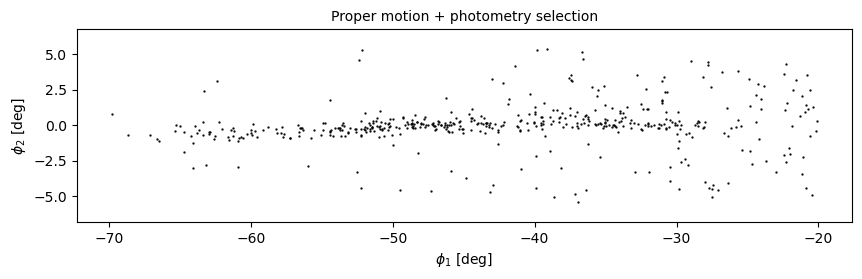

In [84]:
fig = plt.figure(figsize=(10,2.5))
plot_cmd_selection(winner_df)

## Write the data

In [125]:
filename='gd1_data.hdf'
winner_df.to_hdf(filename, key='winner_df')

In [126]:
getsize(filename)/MB

15.510093688964844

# Visualization

## Making Figures that Tell a Story

Improving on defaults
* publication ready
* clear and compelling communication

## Exercise
Look at Figure 1 and think about the following questions:
1. What is the primary scientific result of this work?
2. What story is this figure telling?
3. In the design of this figure, can you identify 1 or 2 choices the authors made that you think are effective? Think about big picture elements, like the number of panels, and how they are arranged, as well as details like the choice of typeface.
4. Can you identify 1 or 2 elements that could be imporved, or that you might have done differently?

## Solution
1. result: adding selection criteria creates a fairly pure selection of the stars in GD1 which reveals substructure in the stream and a larger extent
2. documents the stages of filtering and their effects. Demonstrates methodology for the skeptical reader
3. black and white, minimal use of color, large fonts. would print well, only a few adjustments for low vision accessibility, no adjustments for poor color vision. Annotations guide the reader.
4. Panels that can be aligns are (same axes). Could remove white space around spatial plots. Darker annotations to make them stand out. Make legend in lower right panel bigger

## Plotting GD-1 with Annotations

Figure annotations:
* vertical dashed line to distinguish previously undetected region of GD1
* label identifies the new region
* text+arrow to identify features of GD-1

## Exercise

Plot the selected stars in winner_df using the plot_cmd_selection function and then choose any or all of these features and add them to the figure. 
* to draw vertical lines, see plt.vlines or plt.axvline
* To add text see plt.text
* To add annotations with arrow and text see plt.annotate

Text(-40, 5.5, 'Spur')

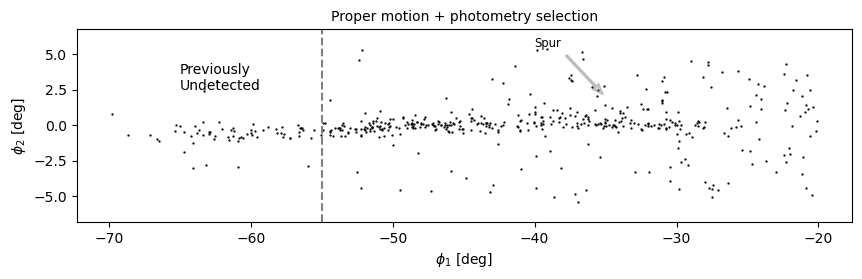

In [85]:
fig = plt.figure(figsize=(10,2.5))
plot_cmd_selection(winner_df)
plt.axvline(-55, ls='--', color='gray')
plt.text(-65, 2.5, 'Previously\nUndetected')
arrowprops=dict(color='gray', shrink=0.05, width=1.5, 
                headwidth=6, headlength=8, alpha=0.4)
plt.annotate('Spur', xy=(-35, 2), xytext=(-40, 5.5),
             arrowprops=arrowprops, fontsize='small')

## Customization

Default style
Override:
* current figure: e.g. tick_params
* notebook: rcParams
* group or common global: style sheet

Note: AAS provides a graphic's guide to ensure the figures you create and styles you define are accessible

To customize more we need to be able to explicitly access our figure and axes objects. Note that matplotlib often interchanges subplot and axes - subplot is an axes object with additional features. 

subplot syntax: fig.add_subplot(ncol, nrows, pltnum)

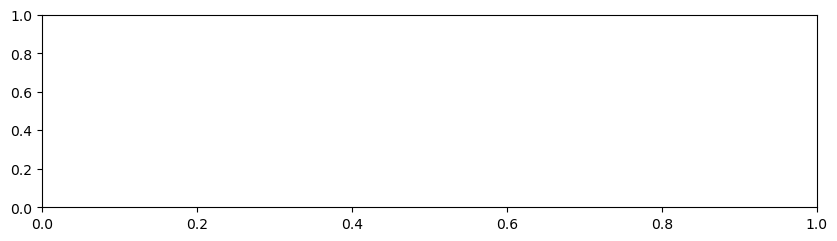

In [97]:
fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(1,1,1)

Let's customize a single plot by putting ticks on the inside of the plot

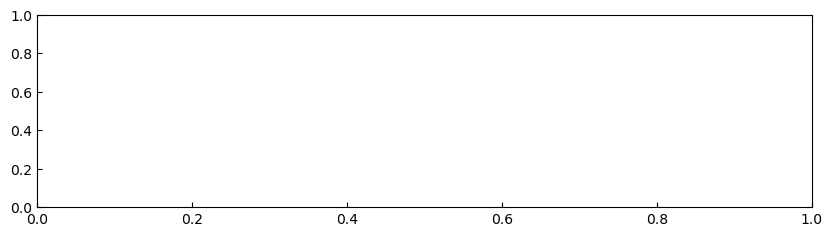

In [98]:
fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(1,1,1)
ax.tick_params(direction='in')

## Exercise: 
Read the documentation of tick_params and use it to put ticks on the top and right sides of the axes

## rcParams

when you import matplotlib it creates a dictionary called rcParams with all of the default values in it

In [99]:
plt.rcParams['font.size']

10.0

In [100]:
plt.rcParams['font.size'] = 14

## Exercise:
Plot the previous figure again and see what effect changing the font size had. Look up any other element of rcParams, change its value, and look at the result

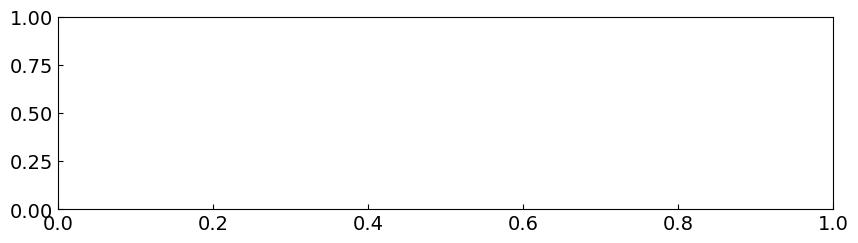

In [101]:
fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(1,1,1)
ax.tick_params(direction='in')

rcParams is populated from your .matplotlibrc file. You can find you matplotlibrc file with

In [102]:
import matplotlib as mpl
mpl.matplotlib_fname()

'/Users/bostroem/.matplotlib/matplotlibrc'

If it doesn't exist - share link

## Style sheets

* setting more than one default
* defining a set of defaults for different situations - create uniform figure style

Pre defined style sheets

In [106]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'az-paper-onecol',
 'az-paper-twocol',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'petroff10',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

note: seaborn-v0_8-paper, seaborn-v0_8-poster, seaborn-v0_8-talk

to use a style sheet

In [104]:
plt.style.use('fivethirtyeight')

return to default

In [105]:
plt.style.use('default')

## Exercise

Choose one of the styles on the list and select it by callinguse. Then go back and plot one of the previous figures to see what changes in the figure's appearance

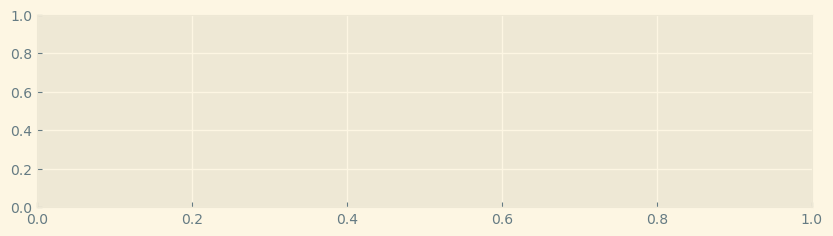

In [107]:
plt.style.use('Solarize_Light2')
fig = plt.figure(figsize=(10, 2.5))
ax = fig.add_subplot(1,1,1)
ax.tick_params(direction='in')

If you don't like an included style file, you can make your own. We have included a style file that I created for my papers called az-paper-twocol. You can use it with

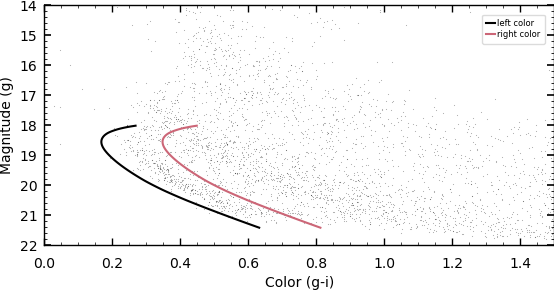

In [110]:
plt.style.use('default')
plt.style.use('./az-paper-twocol.mplstyle')
plot_cmd(candidate_df)
plt.plot(left_color, g, label='left color')
plt.plot(right_color, g, label='right color')

plt.legend();

the ./ tells matplotlib to look for the style file in the current directory.
Alternately put the file in the stylelib in your matplotlib configuration directory. to find that type

In [111]:
mpl.get_configdir()

'/Users/bostroem/.matplotlib'

## Multiple panels
* the figure we want has 4 panels of different sizes
* add_subplot creates equal sized panels
* use subplot2grid to create different sized panels
* subplot2grid takes two arguments: shape: (nrow, ncol) and loc: (panel row, panel col)
* loc (0,0) is upper left panel
* make panels and then use plotting functions to plot into each panel

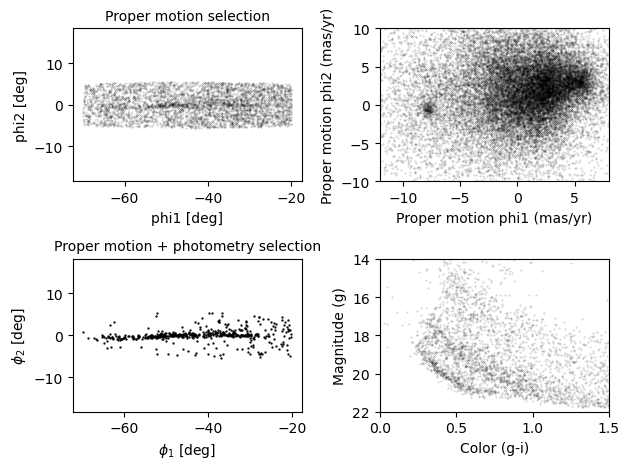

In [112]:
plt.style.use('default')
fig = plt.figure()
shape = (2,2)

ax1 = plt.subplot2grid(shape, (0, 0))
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0, 1))
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1, 0))
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1, 1))
plot_cmd(candidate_df)

plt.tight_layout()

tight_layout autoscales to minimize white space between plots

Note how useful our plotting functions were:
* very little typing
* self documenting, clear code

## Exercise:

What happens if you leave out tight_layout?

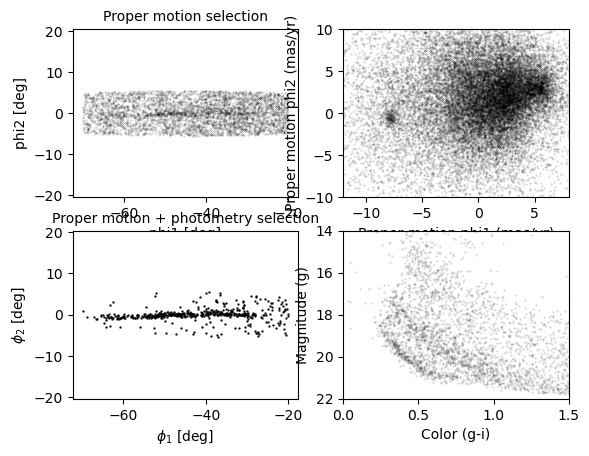

In [114]:
plt.style.use('default')
fig = plt.figure()
shape = (2,2)

ax1 = plt.subplot2grid(shape, (0, 0))
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0, 1))
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1, 0))
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1, 1))
plot_cmd(candidate_df)


## Adjusting proportions

* want to stretch panels on left and compress panels on right
* colspan tells us how many columns an axes will occupy
* adjust figsize to change the total proportions of the figure

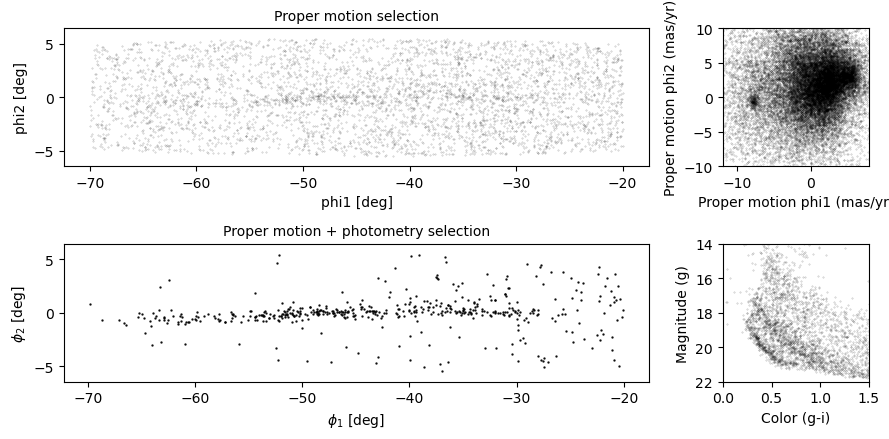

In [113]:
plt.figure(figsize=(9, 4.5))

shape = (2, 4) #More columns than before
ax1 = plt.subplot2grid(shape, (0, 0), colspan=3)
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0, 3))
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1,0), colspan=3)
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1,3))
plot_cmd(candidate_df)

plt.tight_layout()

## Exercise

In this example, the ratio of the widths of the panels is 3:1. How would you adjust it if you wanted the ratio to be 3:2?

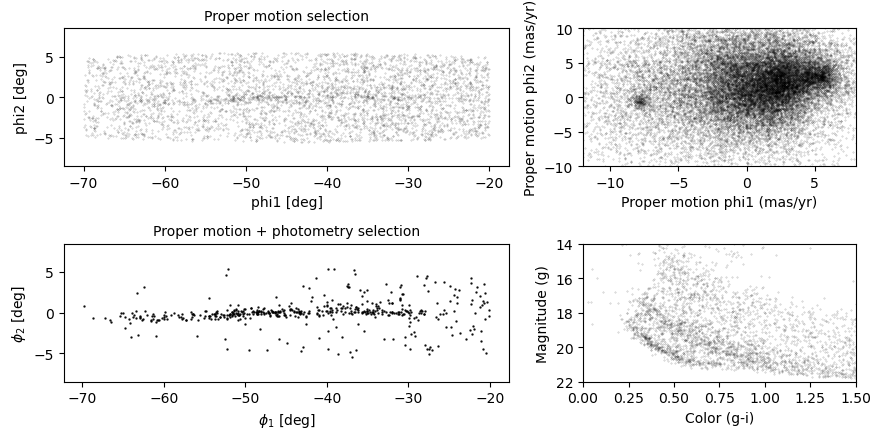

In [115]:
plt.figure(figsize=(9, 4.5))

shape = (2, 5) #change 4 --> 5
ax1 = plt.subplot2grid(shape, (0, 0), colspan=3)
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0, 3), colspan=2) #add colspan=2
plot_proper_motion(centerline_df)

ax3 = plt.subplot2grid(shape, (1,0), colspan=3)
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1,3), colspan=2) # add colspan=2
plot_cmd(candidate_df)

plt.tight_layout()

## Adding the shaded regions

* In episode 4 we defined the vertices of rectangle in pm1_rect and pm2_rect
* Use Matplotlib Polygon from episode 7 to plot
* format: array with an x column and y column

In [117]:
vertices = np.transpose([pm1_rect, pm2_rect])
vertices

array([[-8.9, -2.2],
       [-8.9,  1. ],
       [-6.9,  1. ],
       [-6.9, -2.2],
       [-8.9, -2.2]])

create polygon patch

In [118]:
poly = Polygon(vertices, closed=True, facecolor='orange', alpha=0.4)

Add patch

(-10.0, 10.0)

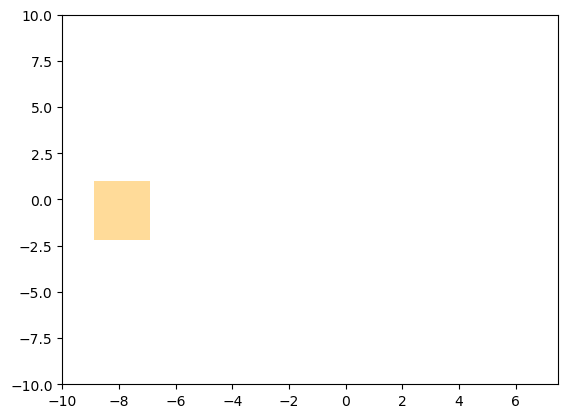

In [119]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
poly = Polygon(vertices, closed=True, facecolor='orange', alpha=0.4)
ax.add_patch(poly)
ax.set_xlim(-10, 7.5)
ax.set_ylim(-10, 10)

Add plot_proper_motion function

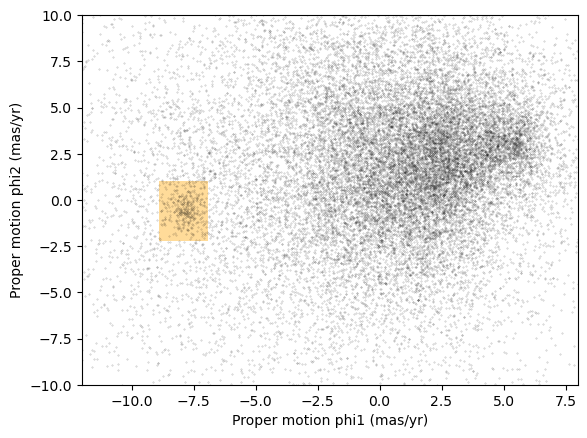

In [120]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plot_proper_motion(centerline_df)
poly = Polygon(vertices, closed=True, facecolor='orange', alpha=0.4)
ax.add_patch(poly)

## Exercise
Add a few lines to be run after the plot_cmd function to show the polygon we selected as a shaded area

Hint: pass loop_df as an argument to Polygon as we did in episode 7 and then plot it using add_patch

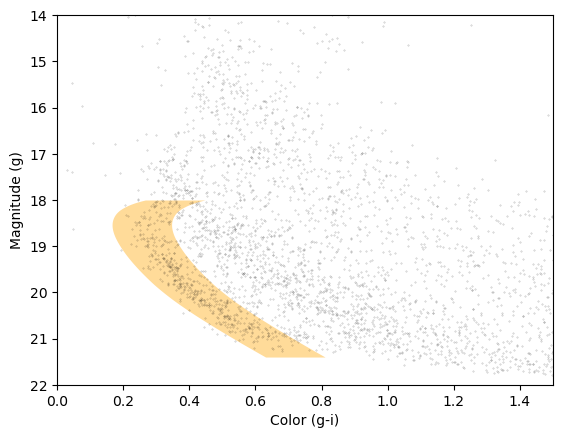

In [122]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plot_cmd(candidate_df)
poly2 = Polygon(loop_df, closed=True, facecolor='orange', alpha=0.4)
ax.add_patch(poly2)

## Exercise
Add the Polygon patches you just created to the right panels of the four panel figure

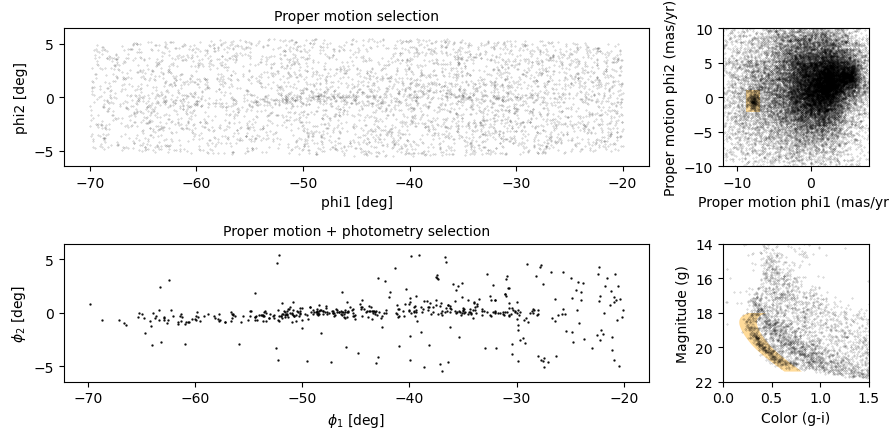

In [124]:
plt.figure(figsize=(9, 4.5))

shape = (2, 4) #More columns than before
ax1 = plt.subplot2grid(shape, (0, 0), colspan=3)
plot_pm_selection(candidate_df)

ax2 = plt.subplot2grid(shape, (0, 3))
plot_proper_motion(centerline_df)
poly = Polygon(vertices, closed=True, facecolor='orange', alpha=0.4)
ax2.add_patch(poly)

ax3 = plt.subplot2grid(shape, (1,0), colspan=3)
plot_cmd_selection(winner_df)

ax4 = plt.subplot2grid(shape, (1,3))
plot_cmd(candidate_df)
poly2 = Polygon(loop_df, closed=True, facecolor='orange', alpha=0.4)
ax4.add_patch(poly2)

plt.tight_layout()